In [15]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [16]:
# Load data
df = pd.read_csv("data/data_random.csv")
print("Data statistics:")
print(df.describe())

Data statistics:
             episode            i_x            i_y            i_z  \
count  500000.000000  500000.000000  500000.000000  500000.000000   
mean   250000.500000      -0.118080     224.943575       0.026721   
std    144337.711635      87.400135     100.947962      87.432840   
min         1.000000    -169.977781      50.000455    -169.967711   
25%    125000.750000     -75.197163     137.534692     -74.927085   
50%    250000.500000      -0.400113     224.825273       0.008221   
75%    375000.250000      74.960342     312.364142      74.942838   
max    500000.000000     169.648130     399.999919     169.827963   

                 f_x            f_y            f_z            w_x  \
count  500000.000000  500000.000000  500000.000000  500000.000000   
mean       -0.110546      -0.248710       0.061295      -0.002842   
std        88.621248       0.151137      88.687470       8.661388   
min      -213.822284      -0.596221    -212.605853     -14.999992   
25%       -75.15

In [17]:
def normalize_X(X):
    """Normalize input features to [-1, 1] range"""
    X[:, 0] = X[:, 0] / 500   # i_x: [-500, 500] -> [-1, 1]
    X[:, 1] = X[:, 1] / 400   # i_y: [0, 400] -> [0, 1] (clip negatives)
    X[:, 2] = X[:, 2] / 500   # i_z: [-500, 500] -> [-1, 1]
    X[:, 3] = X[:, 3] / 15    # w_x: [-15, 15] -> [-1, 1]
    X[:, 4] = X[:, 4] / 15    # w_z: [-15, 15] -> [-1, 1]
    return X

def normalize_y(y):
    """Normalize outputs to [-1, 1] range"""
    y[:, 0] = y[:, 0] / 500   # f_x: [-500, 500] -> [-1, 1]
    y[:, 1] = y[:, 1] / 500   # f_z: [-500, 500] -> [-1, 1]
    return y

def denormalize_x(X):
    """Convert normalized predictions back to original scale"""
    X[:, 0] = X[:, 0] * 500   # i_x: [-500, 500] -> [-1, 1]
    X[:, 1] = X[:, 1] * 400   # i_y: [0, 400] -> [0, 1] (clip negatives)
    X[:, 2] = X[:, 2] * 500   # i_z: [-500, 500] -> [-1, 1]
    X[:, 3] = X[:, 3] * 15    # w_x: [-15, 15] -> [-1, 1]
    X[:, 4] = X[:, 4] * 15    # w_z: [-15, 15] -> [-1, 1]
    return X

def denormalize_y(y_norm):
    """Convert normalized predictions back to original scale"""
    y_original = y_norm.copy()
    y_original[:, 0] *= 500   # f_x
    y_original[:, 1] *= 500   # f_z
    return y_original

In [18]:
# Prepare data
X = df[["i_x", "i_y", "i_z", "w_x", "w_z"]].values
y = df[["f_x", "f_z"]].values

# X_normalized = normalize_X(X)
# y_normalized = normalize_y(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

# Create DataLoader
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=1024, shuffle=True)
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=1024, shuffle=False)


In [19]:
class ImprovedLandingPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),
            
            nn.Linear(32, 2)
        )
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                nn.init.constant_(m.bias, 0.01)
    
    def forward(self, x):
        return self.model(x)

model = ImprovedLandingPredictor()
print(model)

ImprovedLandingPredictor(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): Linear(in_features=128, out_features=64, bias=True)
    (12): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.1)
    (14): Linear(in_features=64, out_features=32, bias=True)
    (15): BatchNorm1d(32, eps=1e-05, momentum=0.

In [20]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Training loop
best_loss = float('inf')
train_losses = []
val_losses = []

epochs = 50
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            val_loss += criterion(outputs, batch_y).item()
    
    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    
    # Early stopping check
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improve += 1
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {avg_train_loss:.15f} | Val Loss: {avg_val_loss:.15f}')
        print(f'Current LR: {optimizer.param_groups[0]["lr"]:.6f}')  # Still available from optimizer

Epoch 1/50:
Train Loss: 6996.050817465233195 | Val Loss: 6530.296760403380176
Current LR: 0.000500
Epoch 5/50:
Train Loss: 2680.564164651934334 | Val Loss: 2124.413188077965515
Current LR: 0.000500
Epoch 10/50:
Train Loss: 33.244412044125141 | Val Loss: 4.593403188549742
Current LR: 0.000500
Epoch 15/50:
Train Loss: 27.102841052862690 | Val Loss: 3.931919134393030
Current LR: 0.000500
Epoch 20/50:
Train Loss: 24.800139244255202 | Val Loss: 2.092900309027458
Current LR: 0.000500
Epoch 25/50:
Train Loss: 24.397079587287610 | Val Loss: 3.038805667234927
Current LR: 0.000500
Epoch 30/50:
Train Loss: 23.292208925232558 | Val Loss: 1.956365198505168
Current LR: 0.000500
Epoch 35/50:
Train Loss: 22.541512028335610 | Val Loss: 2.735111642856987
Current LR: 0.000500
Epoch 40/50:
Train Loss: 21.580737257857457 | Val Loss: 3.278776781899588
Current LR: 0.000500
Epoch 45/50:
Train Loss: 20.832852278219161 | Val Loss: 2.330114041055952
Current LR: 0.000500
Epoch 50/50:
Train Loss: 21.02737895058244

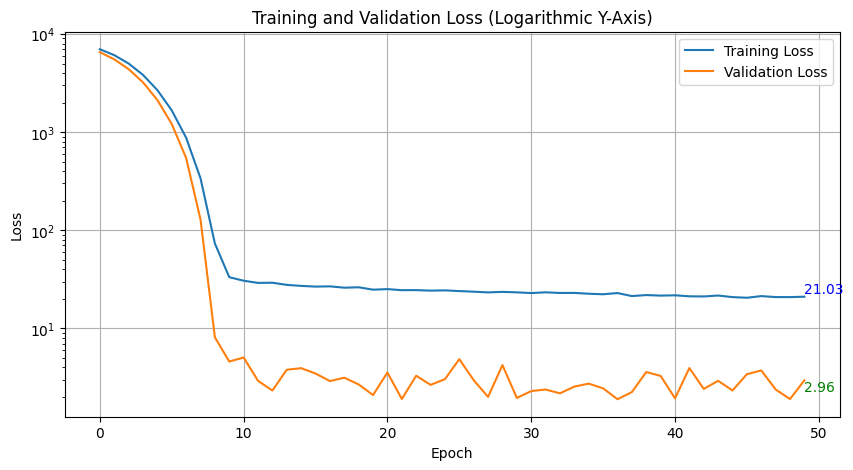

In [26]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Plot training curves with logarithmic y-axis
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')  # Set the y-axis to a logarithmic scale

# Add text annotations for the final loss values
plt.text(len(train_losses) - 1, train_losses[-1], f'{train_losses[-1]:.2f}', 
         verticalalignment='bottom', horizontalalignment='left', color='blue')
plt.text(len(val_losses) - 1, val_losses[-1], f'{val_losses[-1]:.2f}', 
         verticalalignment='top', horizontalalignment='left', color='green')

plt.legend()
plt.title('Training and Validation Loss (Logarithmic Y-Axis)')
plt.grid(True)
plt.show()



Final Test Metrics:
MSE (normalized): 1.896933
MAE: 1.05 meters
RMSE: 1.38 meters


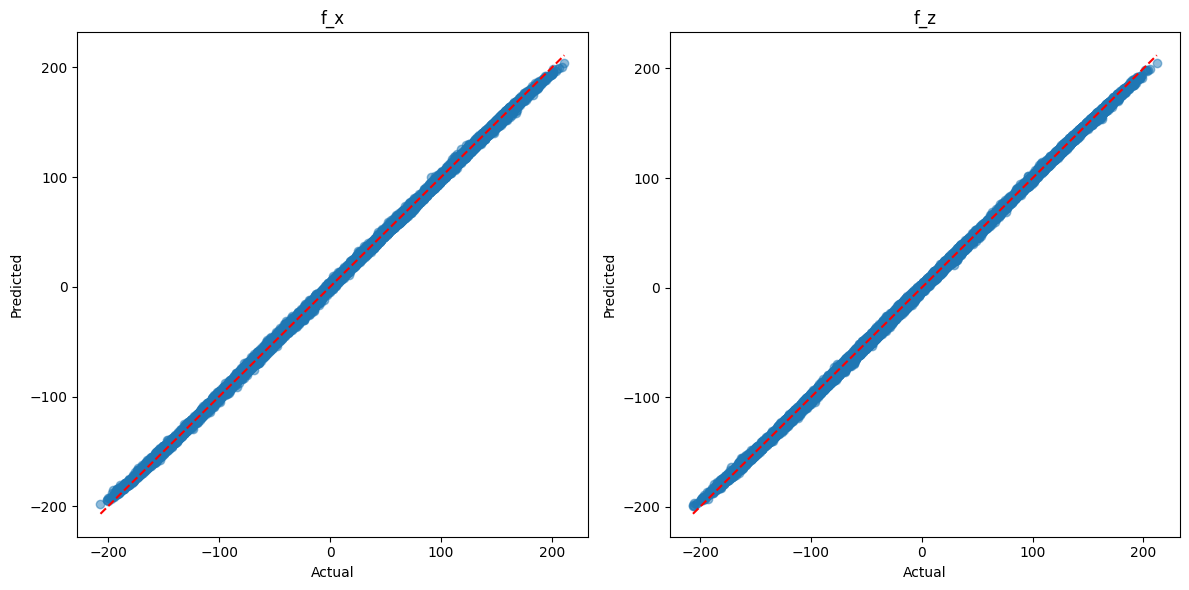


Sample Predictions:
Sample 1:
  Input: [122.4076     70.886345   43.253494    1.0218775  -6.3027315]
  Predicted: [121.556755  42.06466 ]
  Actual:    [122.64686  41.77778]
  Error:     [1.0901031 0.2868805]

Sample 2:
  Input: [ -21.808313   181.1563    -122.814674     8.70161     -2.6124194]
  Predicted: [ -14.677421 -125.51432 ]
  Actual:    [ -13.561082 -125.29068 ]
  Error:     [1.1163387  0.22364044]

Sample 3:
  Input: [ 118.352      395.07535   -127.53401     14.941371     2.6632352]
  Predicted: [ 160.49744  -118.438416]
  Actual:    [ 164.07124 -119.38475]
  Error:     [3.5738068  0.94633484]

Sample 4:
  Input: [-63.84142  288.9924    93.00967   11.806293  13.236378]
  Predicted: [-37.394234 120.174065]
  Actual:    [-39.17989  120.658424]
  Error:     [1.785656   0.48435974]

Sample 5:
  Input: [ 67.69578   242.11636   148.07373     6.3616652  -8.187791 ]
  Predicted: [ 74.27258 135.37334]
  Actual:    [ 76.96249 136.147  ]
  Error:     [2.6899033 0.7736664]



In [22]:
# Evaluation
model.eval()
with torch.no_grad():
    test_preds = model(X_test)
    test_loss = criterion(test_preds, y_test)
    
    # Convert to numpy and denormalize
    preds = test_preds.numpy()
    actual = y_test.numpy()
    
    # Calculate metrics
    mae = np.mean(np.abs(preds - actual))
    rmse = np.sqrt(np.mean((preds - actual)**2))
    
    print(f"\nFinal Test Metrics:")
    print(f"MSE (normalized): {test_loss.item():.6f}")
    print(f"MAE: {mae:.2f} meters")
    print(f"RMSE: {rmse:.2f} meters")
    
    # Plot some predictions
    plt.figure(figsize=(12, 6))
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.scatter(actual[:, i], preds[:, i], alpha=0.5)
        plt.plot([actual[:, i].min(), actual[:, i].max()], 
                [actual[:, i].min(), actual[:, i].max()], 'r--')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(['f_x', 'f_z'][i])
    plt.tight_layout()
    plt.show()

    # Print some examples
    print("\nSample Predictions:")
    for i in range(5):
        print(f"Sample {i+1}:")
        print(f"  Input: {X_test[i].numpy()}")
        print(f"  Predicted: {preds[i]}")
        print(f"  Actual:    {actual[i]}")
        print(f"  Error:     {np.abs(preds[i] - actual[i])}")
        print()